<a href="https://colab.research.google.com/github/juliaviolet/Python_Options/blob/main/Heston_Options_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Heston Model (1993):**

The Heston model is a mathematical model that describes the evolution of the volatility of an asset. This model was proposed by Steven Heston in 1993 as a means to overcome some of the limitations of the Black-Scholes model, specifically, the assumption of constant volatility. The Heston model is a type of stochastic volatility model, which allows the volatility of the asset to be a random process.

The Heston model assumes that the asset price follows a geometric Brownian motion with a stochastic volatility. The model is described by two stochastic differential equations (SDEs), one for the asset price and one for the variance of the asset returns.

The SDE for the asset price $S_t$ under the risk-neutral measure is given by:

$
dS_t = rS_t dt + \sqrt{v_t} S_t dW_t^S
$

and the SDE for the variance $v_t\$ is given by:

$
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW_t^v
$

where $r$ is the risk-free rate, $\kappa$ is the rate of mean reversion of the variance, $\theta$ is the long-term variance, and $\sigma$ is the volatility of the volatility. $W_t^S$ and $W_t^v$ are two Wiener processes with a correlation of $\rho$.

The option price is then given by a risk-neutral expectation of the discounted payoff, which can be computed using various methods such as Monte Carlo simulation, finite difference methods for PDEs, or Fourier transform methods.

The Heston model allows for a rich set of dynamics including volatility clustering and leverage effects (whereby asset returns and volatility are negatively correlated). This makes it a popular choice in the financial industry for modeling equity indices and foreign exchange rates, and for pricing and hedging derivative securities.



<ipython-input-6-06f1cf0ea152>:36: RuntimeWarning: invalid value encountered in sqrt
  asset_paths[t] = asset_paths[t - 1] * np.exp((r - 0.5 * vol_path[t]) * dt + np.sqrt(vol_path[t] * dt) * Z1)
<ipython-input-6-06f1cf0ea152>:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


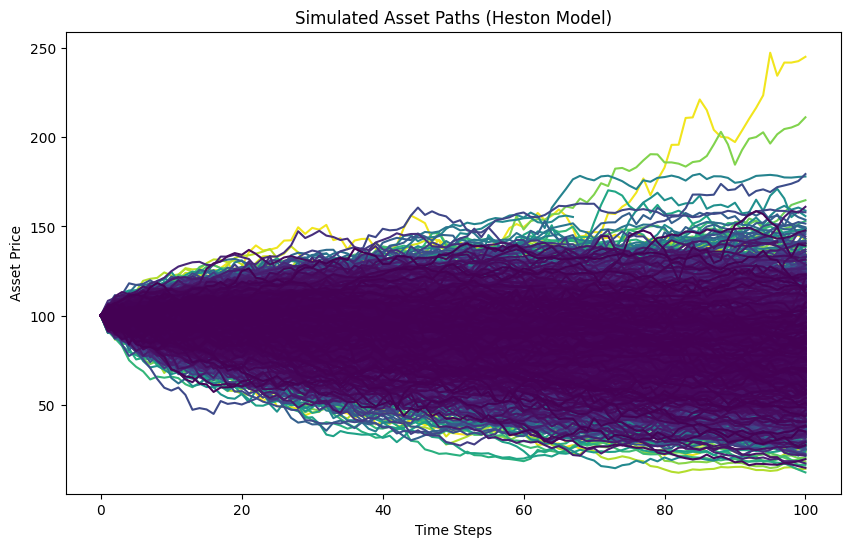

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def generate_asset_paths_Heston(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims):
    '''
    Generates asset paths for a given initial asset price S0, initial volatility v0,
    risk-free rate r, reversion speed kappa, long-term variance theta,
    volatility of variance sigma, correlation rho, total time T, time step dt,
    and number of simulations n_sims.
    '''
    # number of time steps
    N = round(T/dt)

    # array to store asset paths
    asset_paths = np.zeros((N + 1, n_sims))

    # initialize first row with initial asset price
    asset_paths[0] = S0

    # Initialize the volatility path
    vol_path = np.zeros((N + 1, n_sims))
    vol_path[0] = v0

    # simulate asset paths
    for t in range(1, N + 1):
        # Generate correlated random sequences for the Wiener processes
        Z1 = np.random.standard_normal(n_sims)
        Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.standard_normal(n_sims)

        # Update the volatility path
        vol_path[t] = vol_path[t - 1] + kappa * (theta - np.maximum(0, vol_path[t - 1])) * dt + sigma * np.sqrt(np.maximum(0, vol_path[t - 1])) * np.sqrt(dt) * Z2

        # Update the asset path
        asset_paths[t] = asset_paths[t - 1] * np.exp((r - 0.5 * vol_path[t]) * dt + np.sqrt(vol_path[t] * dt) * Z1)

    return asset_paths

# Define your parameters
S0 = 100  # initial asset price
v0 = 0.06  # initial volatility
r = 0.05  # risk-free rate
kappa = 1.15  # speed of reversion
theta = 0.05  # long-term variance
sigma = 0.5  # volatility of variance
rho = -0.65  # correlation between asset price and variance
T = 1.0  # total time
dt = 0.01  # time step
n_sims = 10000  # number of simulations

# generate asset paths
asset_paths = generate_asset_paths_Heston(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims)

# convert to DataFrame for easier viewing
df_asset_paths = pd.DataFrame(asset_paths)

# Plotting
cmap = cm.get_cmap('viridis')
plt.figure(figsize=(10, 6))
colors = cmap(np.linspace(1, 0, n_sims))

for i in range(n_sims):
    plt.plot(df_asset_paths.index, df_asset_paths[i], color=colors[i])

plt.title('Simulated Asset Paths (Heston Model)')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()


The **Carr-Madan Fast Fourier Transform (FFT) method**, introduced by Peter Carr and Dilip Madan, is an efficient numerical method for valuing options based on the Black-Scholes-Merton (BSM) model. This method computes prices for a large number of strike prices by applying the FFT to a modification of the characteristic function implied by the BSM model.

The key insight of the Carr-Madan method is the ability to express the price of a European call option as an inverse Fourier transform of a modified version of the characteristic function of the log asset price. This modification, involving the introduction of a damping factor, ensures quick decay of the integrand in the inverse Fourier transform, making the numerical integration more stable and accurate.

The Carr-Madan FFT method derives from the risk-neutral valuation formula, which states that the price of a derivative is the expected value of its future payoff under the risk-neutral measure, discounted at the risk-free rate. The method proves particularly useful in situations where a large number of option prices need to be computed due to its speed and accuracy.

Here are the steps of the Carr-Madan FFT method:

**Step 1: Setup**

Set up the parameters for the FFT. These include the number of points for the FFT (usually a power of 2, such as 256 or 512), the size of the step in the log-strike space (denoted by \(\Delta\)), and the maximum log-strike.

**Step 2: Define the characteristic function**

The characteristic function of the log asset price under the risk-neutral measure in the BSM model is given by:

$
\phi(u; T) = \exp\left(iu\left(\ln(S_0) + \left(r-\frac{\sigma^2}{2}\right)T\right) - \frac{\sigma^2u^2T}{2}\right)
$

where $T$ is the time to maturity, $S_0$ is the initial asset price, $r$ is the risk-free rate, $\sigma$ is the volatility, and $i$ is the imaginary unit.

**Step 3: Define the modified characteristic function**

Introduce a damping factor into the characteristic function, resulting in the modified characteristic function. The damping factor is introduced to ensure quick decay of the integrand in the inverse Fourier transform, making the numerical integration more stable and accurate.

$
\phi_{\text{mod}}(u; T) = e^{iub}\phi(u-i; T)
$

where \(b\) is the damping factor.

**Step 4: Define the Fourier transform**

Define the Fourier transform of the payoff function of the option. In the case of a European call option, this is given by:

$
C(k) = e^{-rT}\left(e^{kb}\int_0^{\infty} e^{-iu(k-i\Delta)}\phi_{\text{mod}}(u; T) du\right)
$

where \(k\) is the log strike price.

**Step 5: Compute the inverse Fourier transform**

Use the Fast Fourier Transform (FFT) to compute the inverse Fourier transform of the option price for a range of log strike prices.

**Step 6: Obtain option prices**

The output of the FFT is a complex number. The real part gives the option price for a corresponding strike price.

Implementing this method in practice may require additional steps and considerations, such as handling potential numerical instabilities and choosing appropriate parameters.

In [7]:
import time
import numpy as np
import pandas as pd
from scipy.fftpack import fft

# Define the characteristic function

def Heston_characteristic_function(v, x0, T, r, sigma, kappa, theta, rho, v0):
    xi = -0.5 * v ** 2 - 1j * v
    d = np.sqrt((rho * sigma * 1j * v - kappa) ** 2 + sigma ** 2 * (v * 1j + v ** 2))
    g = (kappa - rho * sigma * 1j * v - d) / (kappa - rho * sigma * 1j * v + d)

    # Handle potential division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        cf_value = np.exp((1j * v * (np.log(x0) + r * T) + (kappa * theta) / (sigma ** 2)) * T) * np.exp((kappa * theta) / (sigma ** 2) * (T * (kappa - rho * sigma * 1j * v - d) - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g))))

    # Handle potential invalid values
    cf_value = np.where(np.isfinite(cf_value), cf_value, 0)

    return cf_value

# Calculate the option prices using the Heston model with FFT
def Heston_option_value_FFT(S0, K, T, r, sigma, kappa, theta, rho, v0, option_type):
    k = np.log(K / S0)
    x0 = np.log(S0 / S0)
    g = 1  # factor to increase accuracy
    N = g * 4096
    eps = (g * 150.) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    delt = np.zeros(N, dtype=float)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3

    alpha = 1.5
    v = vo - (alpha + 1) * 1j
    modcharFunc = np.exp(-r * T) * (Heston_characteristic_function(v, x0, T, r, sigma, kappa, theta, rho, v0) / (alpha ** 2 + alpha - vo ** 2 + 1j * (2 * alpha + 1) * vo))
    FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
    payoff = (fft(FFTFunc)).real
    OptionValueM = np.exp(-alpha * k) / np.pi * payoff

    pos = int((k + b) / eps)
    OptionValue = OptionValueM[pos] * S0

    if option_type == 'call':
        return OptionValue
    elif option_type == 'put':
        return OptionValue - S0 + np.exp(-r * T) * K  # put-call parity

# Function to apply our Fourier pricing to each row of the DataFrame
def price_options(row):
    t1 = pd.to_datetime(row['CF_DATE'])
    t2 = pd.to_datetime(row['EXPIR_DATE'])
    T = (t2 - t1).days / 365.0  # convert difference in days to years

    S0 = row['CF_CLOSE']
    K = row['STRIKE_PRC']
    r = 0.02  # risk-free rate
    sigma = row['IMP_VOLT'] / 100  # implied volatility, converted from percentage to fraction

    # Heston model parameters
    kappa = 2.0
    theta = 0.04
    rho = -0.7
    v0 = 0.2359

    if np.isnan(S0) or np.isnan(K) or np.isnan(T) or np.isnan(sigma):
        return np.nan
    if np.isinf(S0) or np.isinf(K) or np.isinf(T) or np.isinf(sigma):
        return np.nan

    if row['PUTCALLIND'] == 'CALL':
        return Heston_option_value_FFT(S0, K, T, r, sigma, kappa, theta, rho, v0, 'call')
    else:  # If it's not a call, it's a put
        return Heston_option_value_FFT(S0, K, T, r, sigma, kappa, theta, rho, v0, 'put')  # use the put pricing function here

start_time = time.time()

# Load the data
df = pd.read_csv('tr_option_data.csv')

# Compute the option prices
df['FOURIER_PRICE'] = df.apply(price_options, axis=1)

end_time = time.time()

print(df)
print(f"Execution time: {end_time - start_time} seconds")


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  FOURIER_PRICE  
0           NaN  12500.47       NaN            NaN  
1       10500.0   2040.80     23.59      

**Why use Monte Carlo methods if FFT methods are available?** Monte Carlo methods, while not the fastest, offer flexibility, making them suitable for pricing exotic derivatives. These derivatives often have complex features that can't be easily implemented using FFT methods. On the other hand, FFT methods are efficient for pricing European type options and are primarily used for calibration.

**Calibration and Pricing:** The process of pricing structured products involves calibrating the model to simple instruments like European type options and extrapolating this information to price exotic derivatives. This strategy may not always work, especially with local volatility models, but it's less of an issue with log-normal stochastic volatility models.

**Monte Carlo vs. FFT:** Monte Carlo methods are mainly used for pricing exotic callable derivatives, while FFT methods offer great speed for European type options. The pricing of European options is a building block used to calibrate the model, which can then be used for more exotic options.

**Pricing Speed:** The speed of pricing is crucial during the calibration phase, where many iterations occur. The optimizer will try various combinations of model parameters to minimize the difference between option prices or implied volatilities from the model and the market.

**Flexibility:** While it's possible to derive FFT for exotic derivatives like Bermudian options, this approach isn't very generic. If an extra feature or parameter is added, the whole method might need to be reworked. However, Monte Carlo methods inherently offer flexibility.

**FFT and Monte Carlo Working Together:** In practice, FFT and Monte Carlo methods are often used together. FFT is used for calibration, while Monte Carlo is used for pricing exotic derivatives.

**Partial Differential Equation (PDE) Methods:** These could be considered a middle ground between FFT and Monte Carlo methods. They can price callable products efficiently but offer less flexibility in terms of payoffs.

Why do we need Monte Carlo if we have FFT methods for pricing? https://www.youtube.com/watch?v=w4U4iZzths8

The **Monte Carlo method** for options pricing involves simulating the underlying asset price paths and then calculating the payoff for each path. The option price is then the discounted expected payoff.

The steps are as follows:

1. Generate a sequence of \(N\) standard normal random variables $Z_1, Z_2, ..., Z_N$.

2. Use these to simulate a sequence of asset prices $S_1, S_2, ..., S_N$ using the geometric Brownian motion model:

   $S_{t+1} = S_t \exp((r - 0.5\sigma^2) \Delta t + \sigma \sqrt{\Delta t} Z_{t+1})$

   where $S_t$ is the asset price at time $t$, $r$ is the risk-free rate, $\sigma$ is the volatility of the asset, and $\Delta t$ is the time step.

3. Calculate the payoff for each simulated asset price path. For a call option, the payoff is $\max(S_N - K, 0)$, and for a put option, it's $\max(K - S_N, 0)$, where $K$ is the strike price.

4. The option price is then the discounted expected payoff:

   $C = e^{-rT} \frac{1}{N} \sum_{i=1}^{N} \max(S_{N}^{(i)} - K, 0)$

   for a call option, and

  $P = e^{-rT} \frac{1}{N} \sum_{i=1}^{N} \max(K - S_{N}^{(i)}, 0)$

   for a put option.


In [11]:
#Heston Monte Carlo pure Python (nested loops)

import csv
import datetime
import math
import random
import pandas as pd
import time

def generate_asset_paths_Heston(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims):
    N = round(T/dt)
    asset_paths = [[0 for _ in range(n_sims)] for _ in range(N + 1)]
    vol_path = [[0 for _ in range(n_sims)] for _ in range(N + 1)]

    for i in range(n_sims):
        asset_paths[0][i] = S0
        vol_path[0][i] = v0

    for t in range(1, N + 1):
        for i in range(n_sims):
            Z1 = random.gauss(0, 1)
            Z2 = rho * Z1 + math.sqrt(1 - rho ** 2) * random.gauss(0, 1)
            vol_path[t][i] = vol_path[t - 1][i] + kappa * (theta - max(0, vol_path[t - 1][i])) * dt + sigma * math.sqrt(max(0, vol_path[t - 1][i])) * math.sqrt(dt) * Z2
            asset_paths[t][i] = asset_paths[t - 1][i] * math.exp((r - 0.5 * vol_path[t][i]) * dt + math.sqrt(vol_path[t][i] * dt) * Z1)

    return asset_paths

def calculate_option_price(paths, K, T, r, option_type):
    payoffs = []
    for path in paths:
        if option_type == "CALL":
            payoff = max(path[-1] - K, 0)
        else:
            payoff = max(K - path[-1], 0)
        payoffs.append(payoff)

    price = math.exp(-r * T) * sum(payoffs) / len(payoffs)
    return price

def calculate_days_between_dates(date1, date2):
    date_format = "%Y-%m-%d"
    a = datetime.datetime.strptime(date1, date_format)
    b = datetime.datetime.strptime(date2, date_format)
    delta = b - a
    return delta.days

S0 = 100
v0 = 0.06
r = 0.05
kappa = 1.15
theta = 0.05
sigma = 0.5
rho = -0.65
T = 1.0
dt = 0.01
n_sims = 10000

start_time = time.time()

df = pd.read_csv('tr_option_data.csv')

def price_options(row):
    if pd.isnull(row['CF_DATE']) or pd.isnull(row['EXPIR_DATE']):
        return None

    T = calculate_days_between_dates(row['CF_DATE'], row['EXPIR_DATE']) / 365.0
    S0 = float(row['CF_CLOSE'])
    K = float(row['STRIKE_PRC'])
    sigma = float(row['IMP_VOLT']) / 100
    option_type = row['PUTCALLIND']

    paths = generate_asset_paths_Heston(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims)
    option_price = calculate_option_price(paths, K, T, r, option_type)

    return option_price

df['MONTE_CARLO_PRICE'] = df.apply(price_options, axis=1)

end_time = time.time()

print(df)
print(f"Execution time: {end_time - start_time} seconds")


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  MONTE_CARLO_PRICE  
0           NaN  12500.47       NaN                NaN  
1       10500.0   2040.80     23.

In [13]:
# Heston Monte Carlo NumPy (fully vectorized)

import datetime
import numpy as np
import pandas as pd
import time

def generate_asset_paths_Heston(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims):
    N = round(T/dt)

    # Standard normally distributed numbers
    Z = np.random.standard_normal(size=(N, n_sims))

    # Initialize asset paths and vol paths
    asset_paths = np.zeros((N, n_sims))
    asset_paths[0] = S0
    vol_path = np.zeros((N, n_sims))
    vol_path[0] = v0

    # Generating paths
    for t in range(1, N):
        Z1 = Z[t]
        Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.standard_normal(n_sims)
        vol_path[t] = vol_path[t - 1] + kappa * (theta - np.maximum(0, vol_path[t - 1])) * dt + sigma * np.sqrt(np.maximum(0, vol_path[t - 1])) * np.sqrt(dt) * Z2
        asset_paths[t] = asset_paths[t - 1] * np.exp((r - 0.5 * vol_path[t]) * dt + np.sqrt(vol_path[t] * dt) * Z1)

    return asset_paths

def calculate_option_price(paths, K, T, r, option_type):
    if option_type == "CALL":
        payoffs = np.maximum(paths[-1] - K, 0)
    else:  # PUT
        payoffs = np.maximum(K - paths[-1], 0)

    price = np.exp(-r * T) * np.mean(payoffs)
    return price

def calculate_days_between_dates(date1, date2):
    date_format = "%Y-%m-%d"
    a = datetime.datetime.strptime(date1, date_format)
    b = datetime.datetime.strptime(date2, date_format)
    delta = b - a
    return delta.days

S0 = 100
v0 = 0.06
r = 0.05
kappa = 1.15
theta = 0.05
sigma = 0.5
rho = -0.65
T = 1.0
dt = 0.01
n_sims = 10000

start_time = time.time()

df = pd.read_csv('tr_option_data.csv')

def price_options(row):
    if pd.isnull(row['CF_DATE']) or pd.isnull(row['EXPIR_DATE']):
        return None

    T = calculate_days_between_dates(row['CF_DATE'], row['EXPIR_DATE']) / 365.0
    S0 = float(row['CF_CLOSE'])
    K = float(row['STRIKE_PRC'])
    sigma = float(row['IMP_VOLT']) / 100
    option_type = row['PUTCALLIND']

    paths = generate_asset_paths_Heston(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims)
    option_price = calculate_option_price(paths, K, T, r, option_type)

    return option_price

df['MONTE_CARLO_PRICE'] = df.apply(price_options, axis=1)

end_time = time.time()

print(df)
print(f"Execution time: {end_time - start_time} seconds")


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  MONTE_CARLO_PRICE  
0           NaN  12500.47       NaN                NaN  
1       10500.0   2040.80     23.

In [15]:
# Heston Monte Carlo numba (dynamically compiled)

import datetime
import numpy as np
from numba import jit, prange
import pandas as pd
import time

@jit(nopython=True)
def generate_asset_paths_Heston(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims):
    N = round(T/dt)

    # Initialize asset paths and vol paths
    asset_paths = np.zeros((N, n_sims))
    asset_paths[0] = S0
    vol_path = np.zeros((N, n_sims))
    vol_path[0] = v0

    # Generating paths
    for t in range(1, N):
        for i in range(n_sims):
            Z1 = np.random.standard_normal()
            Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.standard_normal()
            vol_path[t, i] = vol_path[t - 1, i] + kappa * (theta - np.maximum(0, vol_path[t - 1, i])) * dt + sigma * np.sqrt(np.maximum(0, vol_path[t - 1, i])) * np.sqrt(dt) * Z2
            asset_paths[t, i] = asset_paths[t - 1, i] * np.exp((r - 0.5 * vol_path[t, i]) * dt + np.sqrt(vol_path[t, i] * dt) * Z1)

    return asset_paths

@jit(nopython=True)
def calculate_option_price(paths, K, T, r, option_type):
    if option_type == "CALL":
        payoffs = np.maximum(paths[-1] - K, 0)
    else:  # PUT
        payoffs = np.maximum(K - paths[-1], 0)

    price = np.exp(-r * T) * np.mean(payoffs)
    return price

def calculate_days_between_dates(date1, date2):
    date_format = "%Y-%m-%d"
    a = datetime.datetime.strptime(date1, date_format)
    b = datetime.datetime.strptime(date2, date_format)
    delta = b - a
    return delta.days

S0 = 100
v0 = 0.06
r = 0.05
kappa = 1.15
theta = 0.05
sigma = 0.5
rho = -0.65
T = 1.0
dt = 0.01
n_sims = 10000

start_time = time.time()

df = pd.read_csv('tr_option_data.csv')

def price_options(row):
    if pd.isnull(row['CF_DATE']) or pd.isnull(row['EXPIR_DATE']):
        return None

    T = calculate_days_between_dates(row['CF_DATE'], row['EXPIR_DATE']) / 365.0
    S0 = float(row['CF_CLOSE'])
    K = float(row['STRIKE_PRC'])
    sigma = float(row['IMP_VOLT']) / 100
    option_type = row['PUTCALLIND']

    paths = generate_asset_paths_Heston(S0, v0, r, kappa, theta, sigma, rho, T, dt, n_sims)
    option_price = calculate_option_price(paths, K, T, r, option_type)

    return option_price

df['MONTE_CARLO_PRICE'] = df.apply(price_options, axis=1)

end_time = time.time()

print(df)
print(f"Execution time: {end_time - start_time} seconds")


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  MONTE_CARLO_PRICE  
0           NaN  12500.47       NaN                NaN  
1       10500.0   2040.80     23.

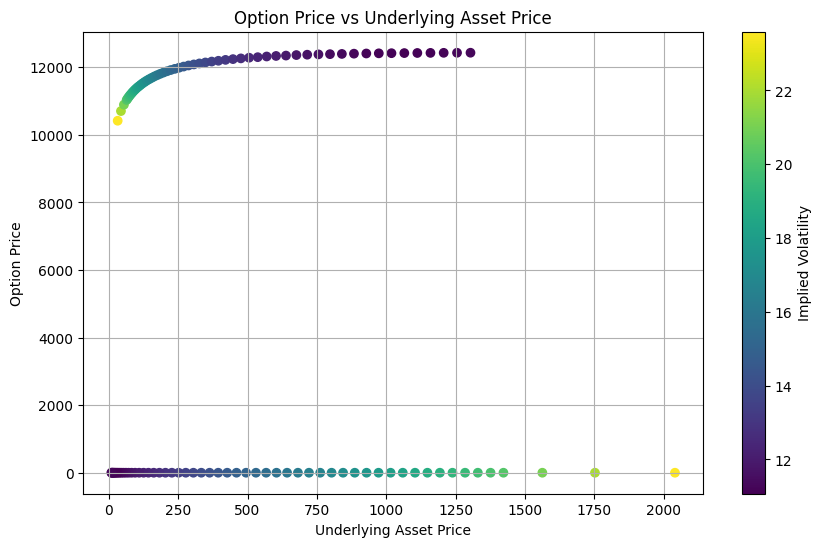

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['CF_CLOSE'], df['FOURIER_PRICE'], c=df['IMP_VOLT'], cmap='viridis')
plt.colorbar(label='Implied Volatility')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Option Price')
plt.title('Option Price vs Underlying Asset Price')
plt.grid(True)
plt.show()


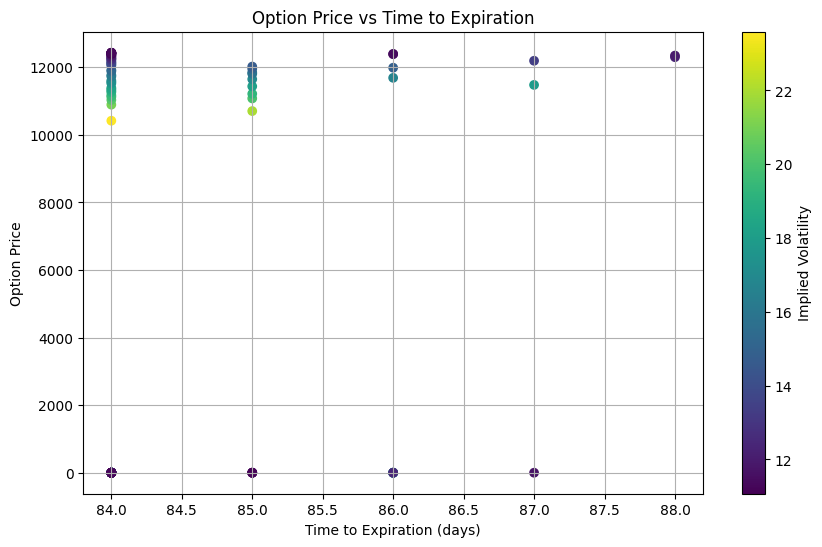

In [9]:
import matplotlib.pyplot as plt

# Calculate Time to Expiration in Days
df['TIME_TO_EXPIRATION'] = (pd.to_datetime(df['EXPIR_DATE']) - pd.to_datetime(df['CF_DATE'])).dt.days

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['TIME_TO_EXPIRATION'], df['FOURIER_PRICE'], c=df['IMP_VOLT'], cmap='viridis')
plt.xlabel('Time to Expiration (days)')
plt.ylabel('Option Price')
plt.title('Option Price vs Time to Expiration')
plt.colorbar(scatter, label='Implied Volatility')
plt.grid(True)
plt.show()


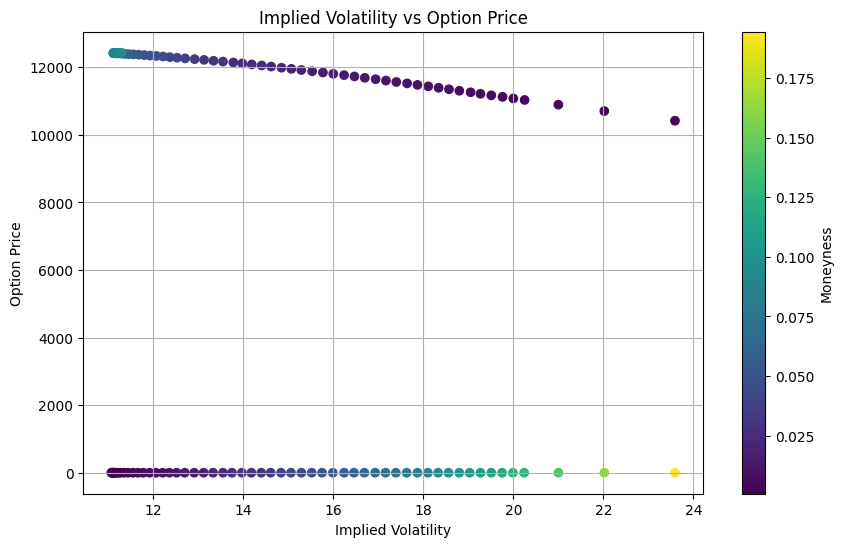

In [10]:
# scatter plot of implied volatility vs option price colored by moneyness

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['IMP_VOLT'], df['FOURIER_PRICE'], c = df['CF_CLOSE'] / df['STRIKE_PRC'], cmap='viridis')
plt.colorbar(label='Moneyness')
plt.xlabel('Implied Volatility')
plt.ylabel('Option Price')
plt.title('Implied Volatility vs Option Price')
plt.grid(True)
plt.show()


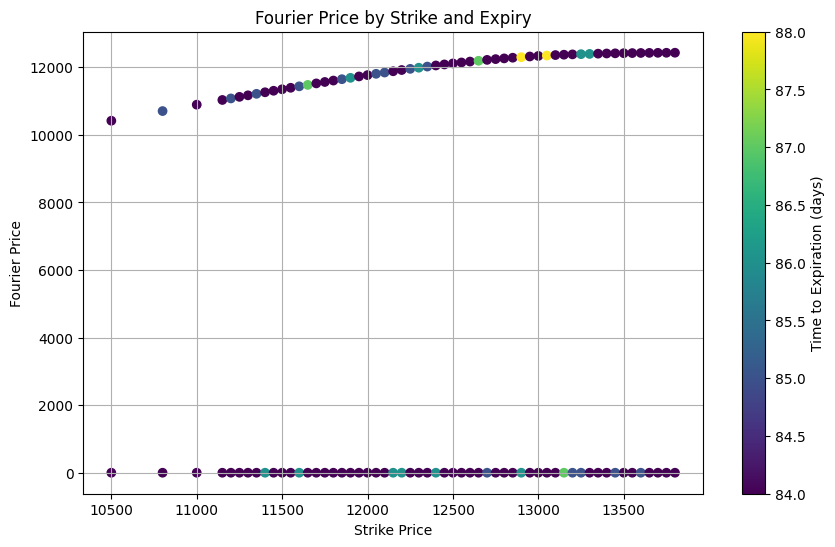

In [11]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['STRIKE_PRC'], df['FOURIER_PRICE'], c=df['TIME_TO_EXPIRATION'], cmap='viridis')
plt.xlabel('Strike Price')
plt.ylabel('Fourier Price')
plt.title('Fourier Price by Strike and Expiry')
plt.colorbar(scatter, label='Time to Expiration (days)')
plt.grid(True)
plt.show()


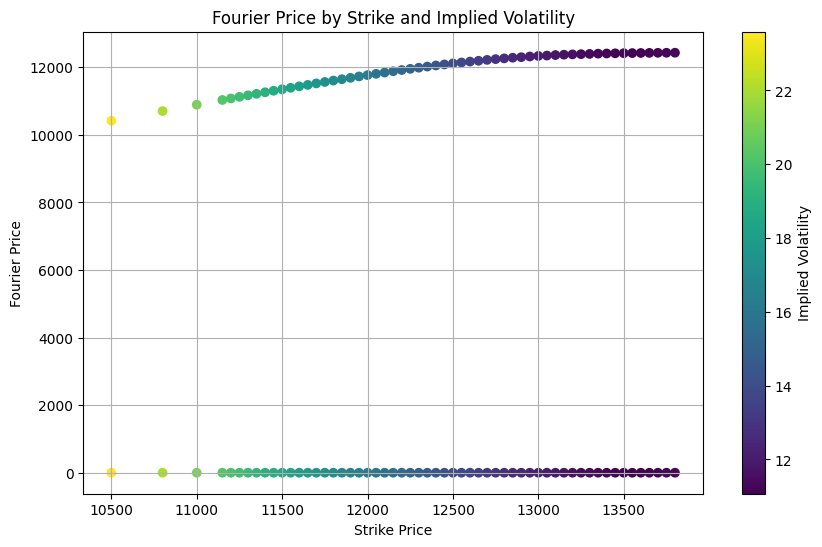

In [12]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['STRIKE_PRC'], df['FOURIER_PRICE'], c=df['IMP_VOLT'], cmap='viridis')
plt.xlabel('Strike Price')
plt.ylabel('Fourier Price')
plt.title('Fourier Price by Strike and Implied Volatility')
plt.colorbar(scatter, label='Implied Volatility')
plt.grid(True)
plt.show()


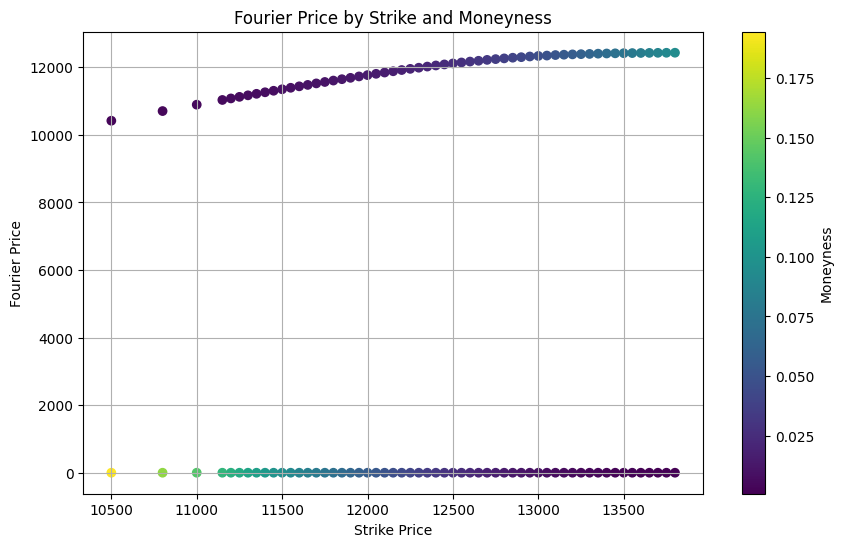

In [13]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['STRIKE_PRC'], df['FOURIER_PRICE'], c = df['CF_CLOSE'] / df['STRIKE_PRC']  # This is just one way to define moneyness
, cmap='viridis')
plt.xlabel('Strike Price')
plt.ylabel('Fourier Price')
plt.title('Fourier Price by Strike and Moneyness')
plt.colorbar(scatter, label='Moneyness')
plt.grid(True)
plt.show()


<ipython-input-14-3eaafb018ed6>:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  scatter.figure.colorbar(sm)


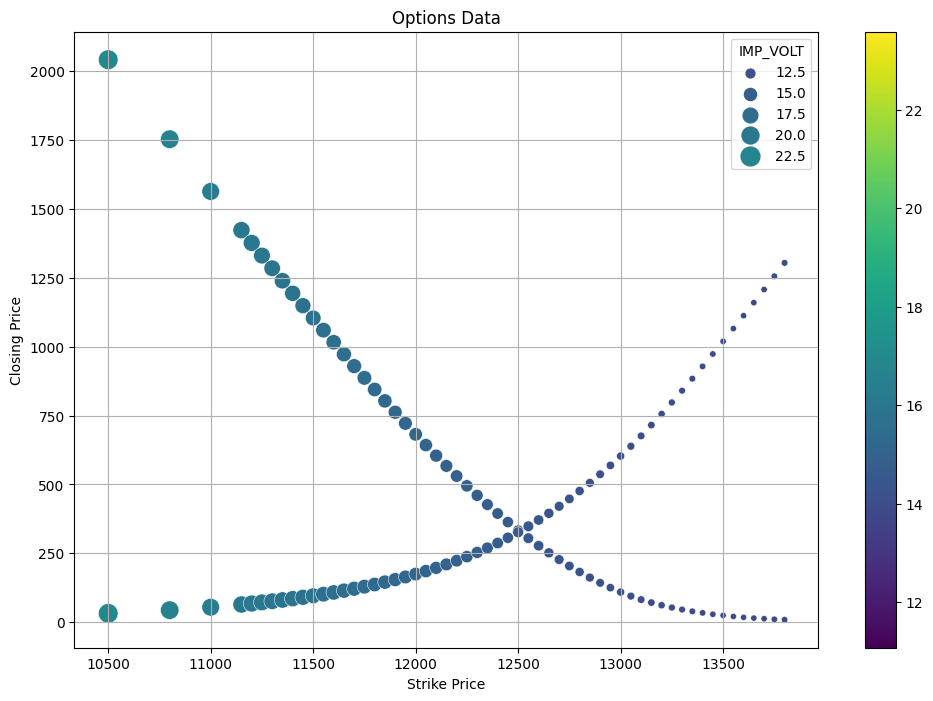

In [14]:
import seaborn as sns
# Filter out rows where PUTCALLIND is not null
options_data = df[~df['PUTCALLIND'].isnull()]

# Create scatterplot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=options_data, x='STRIKE_PRC', y='CF_CLOSE', hue='IMP_VOLT', size='IMP_VOLT', sizes=(20, 200), palette='viridis', hue_norm=(0, 50))

# Adding colorbar
norm = plt.Normalize(df['IMP_VOLT'].min(), df['IMP_VOLT'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
scatter.figure.colorbar(sm)

plt.xlabel('Strike Price')
plt.ylabel('Closing Price')
plt.title('Options Data')
plt.grid(True)
plt.show()
